# Binary-class classification

This file uses the same structure as used in the multi-class classification file.

This file contains a binary classification model and uses image data from a pre-organised file which contains two folders for the two classes, NON-MEL and MEL. 

This file also contains a custom image sampler that allows for different ratios of female:male images to be sampled, for the equal numbers of 6000:6000 and the 1:5 ratio with 2000:10000 images.

In [ ]:
!pip install -U ipython
!pip install -r /content/drive/MyDrive/Dissertation/requirements.txt -qqq
!pip install ipdb -qqq


from datetime import datetime
import json
import torch
import torchvision
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch import argmax
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score
)
from torchsampler import ImbalancedDatasetSampler
import wandb
import numpy as np
from os import listdir
from os.path import join, isdir
from glob import glob
import cv2
import timeit
import timm
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
from collections import Counter
from sklearn.utils import class_weight
from torchvision.transforms import AutoAugment
from operator import itemgetter
import random

from torchvision.transforms.autoaugment import AutoAugmentPolicy

#changing the device to GPU rather than CPU if it is available,
# this will decrease model training time.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device {}".format(device))

torch.manual_seed(17)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using device cuda:0


In [ ]:
class ImageResize(object):
        """
        PIL's resize performs better than pytorch
        https://blog.zuru.tech/machine-learning/2021/08/09/the-dangers-behind-image-resizing
        """

        def __init__(self, new_h, new_w):
            self.new_h = new_h
            self.new_w = new_w

        def __call__(self, image):
            image = image.resize((self.new_w, self.new_h), resample=Image.BILINEAR)
            return image

In [ ]:
class BinaryClassBasedCustomImbalancedDatasetSampler(ImbalancedDatasetSampler):
    def __init__(self, dataset, callback_get_label, male_count, female_count, path_meta_data):
        # mess with dataset
        total_meta_data = pd.read_csv(path_meta_data)

        total_meta_data["class_id"] = [None] * len(total_meta_data)
        for img_path, class_id in zip(dataset.imgs, dataset.targets):
            image_id = img_path[0].split("/")[-1].split(".")[0]
            total_meta_data.loc[total_meta_data["image"] == image_id, "class_id"] = class_id

        train_metadata = total_meta_data.groupby("rand_split").get_group("train")

        sex_group = train_metadata.groupby("sex")
        male_df = sex_group.get_group("male").sample(n=male_count)
        female_df = sex_group.get_group("female").sample(n=female_count)

        filtered_dataset_names = pd.concat([male_df, female_df]).get([
            "image_path", "class_id"
        ]).values

        dataset.imgs = filtered_dataset_names 
        # pass back up
        dataset.targets = [x[1] for x in dataset.imgs]
        dataset.samples = dataset.imgs
        super().__init__(dataset=dataset, callback_get_label=callback_get_label)

## Network generation

Five networks were created using several architectures loaded from the Pytroch library.  Within each model-specific function, the feature extraction layers have been frozen and the final classification layer unfrozen, to allow this final layer to train on our Lesion dataset.

In [ ]:
def create_network_densenet():
        net = models.densenet161(pretrained=True)
        net.classifier = nn.Linear(in_features=2208, out_features=2, bias=True)

        for param in net.parameters():
                param.requires_grad = False
        for param in net.classifier.parameters():
                param.requires_grad = True

        return net


In [ ]:
class ImageFolderWithPaths(ImageFolder):

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

In [ ]:
def run(config):  
    torch.manual_seed(17)
    BASE_PATH = '/content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_2_models/'
    now = str(datetime.now()).replace(":", "-").replace(" ", "_")
    RESULTS_PATH = os.path.join(BASE_PATH, now)
    os.makedirs(RESULTS_PATH, exist_ok=False)

    with open(os.path.join(RESULTS_PATH, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    if config.get("use_wandb"):
        # this integrates the third-party platform, Weights and Biases,
        # with this notebook.
        run = wandb.init(
            project="part_2_skin_lesion",
            entity="sarahlouise",
            config=config,
        )

    batch_size = config["batch_size"]
    Imagenet_NV = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    print("Configuring datasets")
    trainset = ImageFolder(
        os.path.join(config.get("data_path"), 'train'),
        transform=transforms.Compose([
                            transforms.RandomVerticalFlip(0.5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomApply(nn.ModuleList([transforms.RandomRotation(degrees=(0, 360))]), p=0.2),
                            ImageResize(224,224),
                            transforms.PILToTensor(),
                            transforms.ConvertImageDtype(torch.float),
                            transforms.Normalize(*Imagenet_NV),
                        ])
        )
    
    imbalanced_sampler_choice = [
        config.get("use_binary_gender_custom_imbalanced_sampler"),
        config.get("use_imbalanced_sampler"),
    ]
    if imbalanced_sampler_choice.count(True) > 1:
        raise ValueError("Pick one sampler only")

    elif config.get("use_binary_gender_custom_imbalanced_sampler"):
        sampler = BinaryClassBasedCustomImbalancedDatasetSampler(
            dataset=trainset,
            callback_get_label=lambda x: x.targets,
            male_count=config.get("male_count"),
            female_count=config.get("female_count"),
            path_meta_data=config.get("path_meta_data"),
        )
        shuffle = False
    elif config.get("use_imbalanced_sampler"):
        sampler = ImbalancedDatasetSampler(
            trainset,
            callback_get_label=lambda x: x.targets,
        )
        shuffle = False
    else:
        sampler = None
        shuffle = True

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        num_workers=2,
        sampler=ImbalancedDatasetSampler(
            trainset,
            callback_get_label=lambda x: x.targets
    ))

    valset = ImageFolder(
        os.path.join(config.get("data_path"), 'val'),
        transform=transforms.Compose([
                            ImageResize(224,224),
                            transforms.PILToTensor(),
                            transforms.ConvertImageDtype(torch.float),
                            transforms.Normalize(*Imagenet_NV),
                        ]))

    valloader = torch.utils.data.DataLoader(
        valset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    testset = ImageFolderWithPaths(
        os.path.join(config.get("data_path"), 'test'),
        transform=transforms.Compose([
                                ImageResize(224,224),
                                transforms.PILToTensor(),
                                transforms.ConvertImageDtype(torch.float),
                                transforms.Normalize(*Imagenet_NV),
                            ]))

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )
    
    classes = sorted(os.listdir(os.path.join(config.get("data_path"), 'train')))

    if config.get("use_wandb"):
        wandb.sklearn.plot_class_proportions(
            trainset.targets,
            testset.targets,
            classes
        )


    net = create_network_densenet()
    print(f"Moving network to {device}")
    net = net.to(device)

    # ## Training configurations
    
    # defining the training configurations
    no_of_epochs = config["epochs"]
    
    # calculating class weights

    labels = np.array(trainset.targets)
    criterion = nn.CrossEntropyLoss().to(device)

    optimizer = optim.Adam(
        net.parameters(),
        lr=config["lr"],
        amsgrad=config["use_amsgrad"]
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        round((len(trainset)/batch_size)*no_of_epochs)
        )


    # ##  Model training
    #
    # This section included the training for the model. The network was set to train, a mini-batch was passed through the model and then the loss was then backpropagated. Each trained model was also automatically saved.

    if config.get("use_wandb"):
        wandb.watch(net)

    if not config.get("use_pretrained"):
        print("Starting training")
        for epoch in range(no_of_epochs):  # loop over the dataset multiple times
            print("Epoch {} of {}".format(epoch+1, no_of_epochs))
            epoch_running_loss = []
            epoch_val_metric = []
            for i, data in tqdm(enumerate(trainloader, 1), total=len(trainloader)):
                current_step = (len(trainloader) * epoch) + i
                
                # get the inputs; data is a list of [inputs, labels]
                net.train()
                
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward
                outputs = net(inputs)

                
                # outputs = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                scheduler.step()

                # saving loss statistics
                loss_val = loss.item()
                if config.get("use_wandb"):
                    wandb.log(
                        {
                            "train/bce_logits_loss": loss_val,
                            "train/lr": scheduler.get_last_lr()[0],
                            "train/custom_step": (len(trainloader) * epoch) + i,
                        }
                    )

                # adding in valiation data testing
                if i % round(40*config.get("percent_keep", 1)) == 0:
                    model_name = "{name}-epoch-{epoch}-step-{step}.pth".format(
                        name=config["name"],
                        epoch=epoch,
                        step=i,
                    )
                    model_path = os.path.join(RESULTS_PATH, model_name)
                    # Commenting out to save space
                    # torch.save(net.state_dict(), model_path)

                    predicted = []
                    actual = []

                    print("Running validation")
                    net.eval()
                    with torch.no_grad():
                        for i, data in enumerate(tqdm(valloader, total=len(valloader))):
                            inputs, labels = data
                            inputs = inputs.to(device)
                            labels = labels.to(device)

                            outputs = net(inputs)
                            loss = criterion(outputs, labels)
                            if config.get("use_wandb"):
                                wandb.log({
                                    "val/loss": loss,
                                    "val/custom_step": current_step,
                                })

                            # collect the correct predictions for each class
                            actual.extend(labels.detach().cpu().numpy())
                            predicted.extend(torch.argmax(outputs, 1).detach().cpu().numpy())

                        mb_acc = accuracy_score(actual, predicted)
                        precision = precision_score(actual, predicted, average="macro", zero_division = 1)
                        recall = recall_score(actual, predicted, average="macro", zero_division = 1)
                        f1 = f1_score(actual, predicted, average="macro", zero_division = 1)
                        bal_acc = balanced_accuracy_score(actual, predicted)
                        metric_report = classification_report(
                            np.array(actual),
                            np.array(predicted),
                            output_dict=True,
                            zero_division=1,
                        )
                        metric_report = {
                            f"val_classes/{k}": v
                            for k, v in metric_report.items()
                        }
                        metric_report.update({
                            "val_classes/custom_step": current_step,
                        })

                        if config.get("use_wandb"):
                            wandb.log({
                                "val/accuracy": mb_acc,
                                "val/precision": precision,
                                "val/recall": recall,
                                "val/f1": f1,
                                "val/balanced_acc": bal_acc,
                                "val/custom_step": current_step
                            })
                            wandb.log(metric_report)



        print('Finished Training')
        # saving each trained model
        model_name = '{}-final.pth'.format(
            config["name"]
        )
        model_path = os.path.join(RESULTS_PATH, model_name)
        torch.save(net.state_dict(), model_path)

        print("Final model saved")

    # ##  Model testing
    #
    # The model was set to evaluate mode for testing. The predicted and actual results were saved, and used for generating a confusion matrix and metrics.
    #
    # A confusion matrix was generated, showing the number of true positives and negatives, and false positives and negatives. Additionally, the metrics were calculated, including the accuracy score, precision and recall. The corresponding graphs were created using Weights and Biases.


    if config.get("use_pretrained"):
        net.load_state_dict(
            torch.load(
                config.get("use_pretrained")
            )
        )

    predicted = []
    actual = []
    image_paths = []
    
    print("Testing model")
    # again no gradients needed
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(testloader, total=len(testloader))):
            inputs, labels, paths = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            actual.extend(labels.detach().cpu().numpy())
            predicted.extend(torch.argmax(outputs, 1).detach().cpu().numpy())
            image_paths.extend(paths)


    results = pd.DataFrame.from_dict(
        {
            "predicted": predicted,
            "actual": actual,
            "image_path": image_paths
        }
    )
    results.to_csv(os.path.join(RESULTS_PATH, "each_image_predictions.csv"))


    print("Calculating performance metrics")
    model_accuracy = accuracy_score(actual, predicted)
    model_precision = precision = precision_score(actual, predicted,
                                                average="macro", zero_division = 1)
    model_recall = recall_score(actual, predicted,
                                average="macro", zero_division = 1)
    model_f1 = f1_score(actual, predicted, average="macro", zero_division = 1)
    model_bal_acc = balanced_accuracy_score(actual, predicted)
    metric_report = classification_report(
        np.array(actual),
        np.array(predicted),
        output_dict=True,
        zero_division=1,
    )
    metric_report = {
        f"test_classes/{k}": v
        for k, v in metric_report.items()
    }

    if config.get("use_wandb"):
        wandb.log({"test/accuracy": model_accuracy})
        wandb.log({"test/precision": model_precision})
        wandb.log({"test/recall": model_recall})
        wandb.log({"test/f1": model_f1})
        wandb.log({"test/bal_acc": model_bal_acc})
        wandb.sklearn.plot_confusion_matrix(actual, predicted, classes, normalize="true")
        wandb.log(metric_report)
    else:
        print("test/accuracy", model_accuracy)
        print("test/precision", model_precision)
        print("test/recall", model_recall)
        print("test/f1", model_f1)
        print("test/bal_acc", model_bal_acc)

    plot_save_path = os.path.join(RESULTS_PATH, '{}_confusion_matrix.png'.format(
        config["name"]
    ))
    print("Plotting confusion matrix in {}".format(plot_save_path))

    print("Calculating")
    conf_matrix = confusion_matrix(y_true=actual, y_pred=predicted, normalize="true")
    print("Done")
    fig =plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(conf_matrix, cmap=plt.cm.Reds)


    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.savefig(plot_save_path)
    # plt.show()

    if config.get("use_wandb"):
        run.finish()


wandb: Currently logged in as: sarahlouise. Use `wandb login --relogin` to force relogin


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 83%|████████▎ | 39/47 [12:15<01:46, 13.30s/it]

Running validation



100%|██████████| 47/47 [13:56<00:00, 17.79s/it]

Epoch 2 of 5



 83%|████████▎ | 39/47 [06:02<01:13,  9.14s/it]

Running validation



100%|██████████| 47/47 [07:18<00:00,  9.32s/it]

Epoch 3 of 5



 83%|████████▎ | 39/47 [04:27<00:50,  6.33s/it]

Running validation



100%|██████████| 47/47 [05:39<00:00,  7.22s/it]

Epoch 4 of 5



 83%|████████▎ | 39/47 [03:37<00:41,  5.24s/it]

Running validation



100%|██████████| 47/47 [04:48<00:00,  6.14s/it]

Epoch 5 of 5



 83%|████████▎ | 39/47 [03:16<00:44,  5.58s/it]

Running validation



100%|██████████| 47/47 [04:22<00:00,  5.58s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_2_models/2022-06-28_18-26-31.230005/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,▂█▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▇█▁▆▅
val/balanced_acc,▁▆▆██


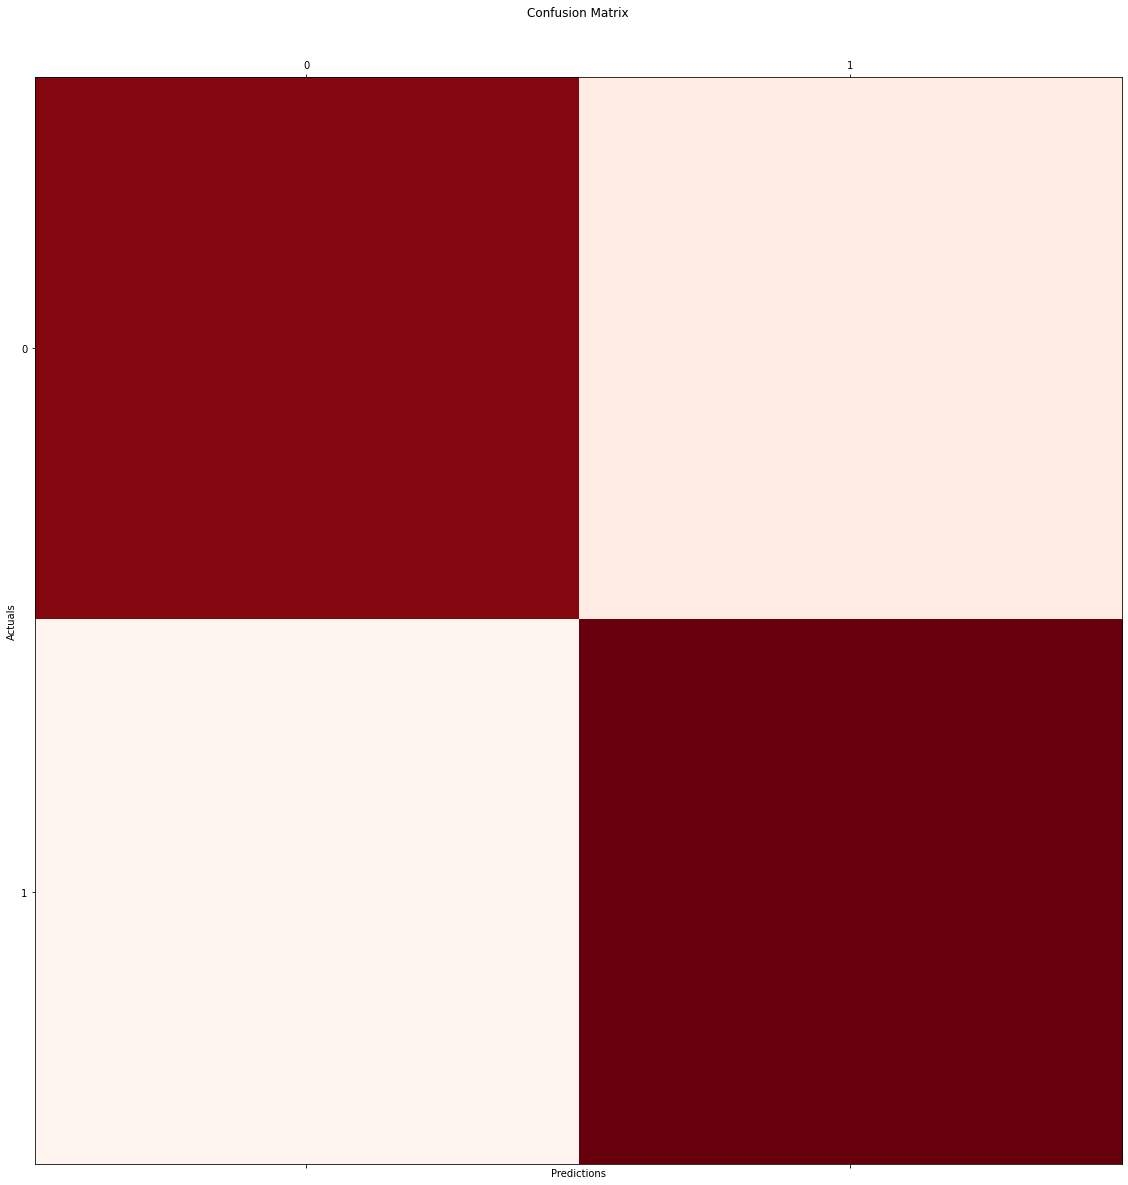

In [ ]:
#from part_2 import run

conf = {
    "epochs": 5,
    "batch_size": 256,
    "lr": 1e-2,
    "name": "densenet",
    "use_wandb": True,
    "use_amsgrad": True,
    "data_path": "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro_binary",
    "use_imbalanced_sampler": False,
    "use_binary_gender_custom_imbalanced_sampler": True,
    "male_count": 6000,
    "female_count": 6000,
    "path_meta_data": "/content/drive/MyDrive/Dissertation/skin_lesion_data/mel_vs_nonmel.csv",
}
run(conf)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')